# Redes Generativas Adversarias: Modelo base

En este notebook se presentará a ejecución del modelo base de las **Redes Generativas Adversarias** (GAN en sus siglas en inglés). El presente modelo está basado en la implementación en Tensorflow de "Vanilla GAN", ubicado en [este repositorio](https://github.com/wiseodd/generative-models). Dicha implementación corresponde al modelo original propuesto por un paper de [NIPS 2014 por Ian Goodfellow, et al.](http://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf). Se utilizará la base de datos MNIST, utilizada por el Goodfellow et al. [2014] y disponible en la librería de tensorflow. 

## Dependencias necesarias:

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from keras.datasets import mnist #Dataset de Keras (modif de la implementacion base)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Inicialización de pesos en las capas de la red

En el modelo base se utiliza *Xavier initialization*. Este método de inicialización de pesos ayuda a que la varianza se mantenga similar en las diferentes capas la red neuronal. Esto evita que la magnitud de la señal de entrada a cada capa se dispare, o disminuya considerablemente. En el [paper original](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf), los autores proponen la siguiente fórmula:


 $$ Var(W_i) = \frac{1}{N_i} $$

Donde:
- $ i $: Iterador que identifica cada capa de la red neuronal
- $ W_i $: Pesos de las neuronas de la capa **"i"**
- $ N_i $: Cantidad de neuronas de la capa **"i"**

La varianza calculada para cada capa a partir de la fórmula arriba se utiliza para generar pesos aleatorios por capa, a partir de una distribución normal estándar:

\begin{equation}
W_i \sim \mathcal{N}(\mu = 0 , \sigma = \sqrt{\frac{1}{N_i}})
\end{equation}

Debido a que se utilizará una función de activación ReLU, se utilizará una modificación de la inicialización Xavier, la inicialización presentada por He et al. [2015](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf)  

$$ W_i \sim \mathcal{N}(\mu = 0 , \sigma = \sqrt{\frac{2}{N_i}}) $$ 


La implementación en Python es la siguiente:

In [2]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

## Definición de la arquitectura GAN:

Inicialmente se utilizará 2 redes neuronales del tipo **perceptrón multicapa**, con 2 capas ocultas. En este sentido, se definen los siguientes elementos de Tensorflow:

- *Placeholders*: Son las entradas de la red. Llámense **"X"** para la red discriminadora y **"Z"** para la red generadora
- *Variables*: Son los parámetros que se modificarán a través del entrenamiento de la red. Se definen los pesos **"W"** y sesgos **"b"** para cada capa y red

Finalmente, se almacenan los valores de los "W" y "b" en 2 listas, theta_D y theta_G (una para cada red):

In [3]:
# Definición de variables de entrada, salida y parámetros:
X = tf.placeholder(tf.float32, shape=[None, 784])

D_W1 = tf.Variable(xavier_init([784, 128]))
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2 = tf.Variable(xavier_init([128, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


Z = tf.placeholder(tf.float32, shape=[None, 100])

G_W1 = tf.Variable(xavier_init([100, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, 784]))
G_b2 = tf.Variable(tf.zeros(shape=[784]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

### Función de activación
Se utiliza una función RELU (*Rectifying Linear Unit*) después de cada capa oculta. En la capa de salida, se utiliza una función sigmoidal para computar una probabilidad entre 0 y 1.

In [4]:
def sample_Z(m, n): 
    #esta función genera el ruido aleatorio que es input de la función generadora Z.
    return np.random.uniform(-1., 1., size=[m, n])


def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1) #Primera capa que se activa con ReLU y utiliza el ruido como input
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2 #Calcula el resultado de la segunda capa aún sin activarse
    G_prob = tf.nn.sigmoid(G_log_prob) #Activación sigmoidal de la última capa que otorga un rango de [0,1] a cada neurona final

    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1) #Primera capa que se activa con ReLU y utiliza los datos MNIST como input
    D_logit = tf.matmul(D_h1, D_W2) + D_b2 #Calcula el resultado de la segunda capa aún sin activarse
    D_prob = tf.nn.sigmoid(D_logit) #Activación sigmoidal de la última capa que otorga un rango de [0,1] a cada neurona final


    return D_prob, D_logit


def plot(samples): #Función que plotea las muestras
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig



## Funciones de pérdida

La red Discriminadora y la red Generadora tienen una función de pérdida diferente:

- Pérdida de la red Discriminadora: La denominaremos **D_loss**
\begin{equation}
\frac{1}{m} \sum^m_{i=1} [ \log D (x^{(i)}) + \log (1 - D(G(z^{(i)})))]
\end{equation}

- Pérdida de la red generadora: La denominaremos **G_loss**
\begin{equation}
\frac{1}{m} \sum^m_{i=1} \log (1 - D(G(z^{(i)})))
\end{equation}

En este caso, de acuerdo a las sugerencias del artículo, se expreso la función **G_loss** como una función de ganancia para que fuese maximizada: 

\begin{equation}
\frac{1}{m} \sum^m_{i=1} \log (D(G(z^{(i)})))
\end{equation}





Se utilizarán las gradientes de dichas funciones por separado para entrenar una red a la vez, ya que no hay solución factible para la optimización en conjunto.

## Algoritmo de entrenamiento:

En la presente implementación, se utilizará el algoritmo de entrenamiento descrito por los autores del modelo, con ciertas modificaciones. Se define un número de iteraciones de entrenamiento y por cada iteración se aplicará una serie de operaciones sobre un **lote de "m" elementos**, las cuales llevarán a la actualización de los pesos y sesgos de las redes a través de la regla de aprendizaje **Adam** (Adaptive Momentum), la cual está basada en gradientes. Este método se conoce como *mini-batch gradient descent* y se detalla a continuación:

**for** número de iteraciones de entrenamiento **do**
1. Muestrear un lote de *m* muestras $\{z^{(1)},...,z^{(m)}\}$, cada una representando ruido aleatorio (100 números por muestra) generados a partir de una función uniforme $ U (-1,1) $.
1. Muestrear un lote de *m* elementos $\{x^{(1)},...,x^{(m)}\}$ del conjunto de datos original (cuya distribución se desea modelar) 
1. Actualizar los pesos y *bias* de la red Discriminadora ("D"), los cuales están almacenados como **theta_D** a través de la gradiente de su función de pérdida (**D_loss**)

1. Muestrear un lote de *m* muestras $\{z^{(1)},...,z^{(m)}\}$, generados nuevamente a partir de una función uniforme $ U (-1,1) $
1. Introducir el set **z** como entrada a la red Discriminadora ("D")
1. Actualizar los pesos y *bias* de la red Generadora ("G"), los cuales están almacenados como **theta_G** a través de la gradiente de su función de pérdida (**G_loss**)

**end for**

Nótese que primero se entrena a la red Discriminadora y luego a la red Generadora.

In [5]:
G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

# Función de pérdida para la red generadora:
D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))

# Función de pérdida para la red discriminante:
G_loss = -tf.reduce_mean(tf.log(D_fake))

In [6]:
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)


## Entrenamiento del modelo GAN

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../../MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


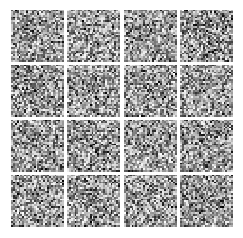

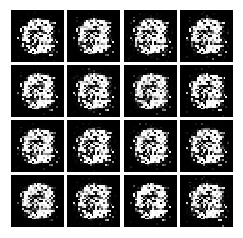

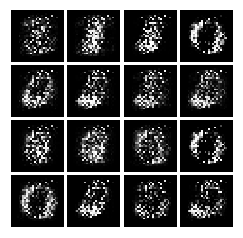

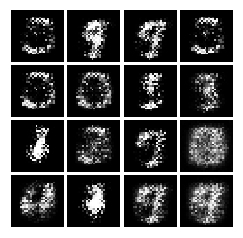

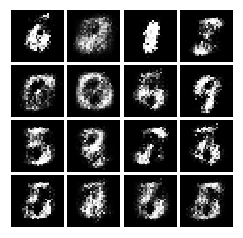

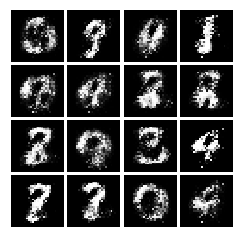

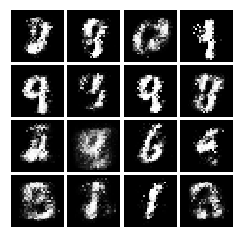

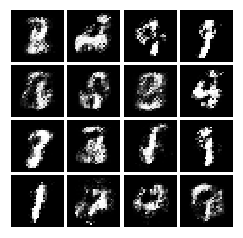

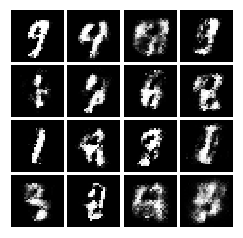

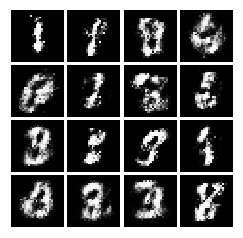

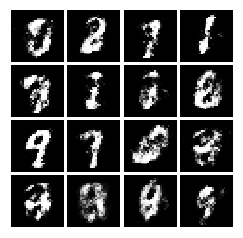

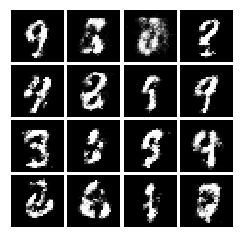

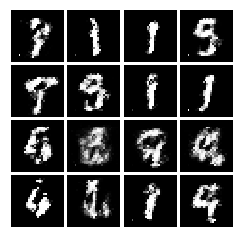

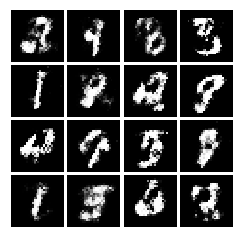

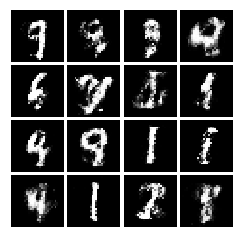

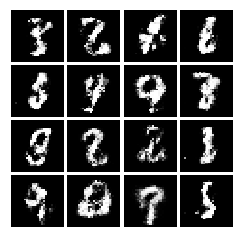

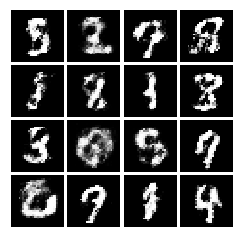

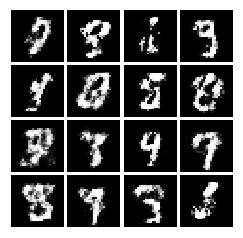

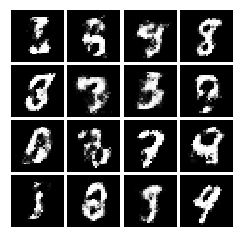

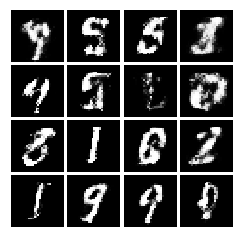

In [7]:
# Usaremos el dataset MNIST:
mb_size = 128
Z_dim = 100
num_iteraciones=20000

mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

for it in range(num_iteraciones):
    if it % 1000 == 0:
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.show(fig)
        plt.close(fig)

    X_mb, _ = mnist.train.next_batch(mb_size)

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

    #if it % 1000 == 0:
    #    print('Iter: {}'.format(it))
    #    print('D loss: {:.4}'. format(D_loss_curr))
    #    print('G_loss: {:.4}'.format(G_loss_curr))
    #   print()
